In [22]:
!pip install pytesseract matplotlib seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:

import os
import fitz  # PyMuPDF
import pytesseract
import pandas as pd
import yfinance as yf
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from PIL import Image
from io import BytesIO
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler



In [8]:

tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")


In [14]:
def extract_pdf_data(pdf_path):
    import fitz  # PyMuPDF
    doc = fitz.open(pdf_path)
    text = ""
    images = []
    keywords = ["income", "balance", "cash flow", "profit", "loss", "statement"]

    for page in doc:
        page_text = page.get_text()
        text += page_text

        # Use keyword-based filtering + table image detection
        blocks = page.get_text("dict")["blocks"]
        has_table = False

        for block in blocks:
            # Check if block has 'text' before using it
            if block.get("type") == 0 and "text" in block:
                block_text = block["text"].lower()
                if any(keyword in block_text for keyword in keywords):
                    has_table = True

            # Extract image only if tables are likely present
            if has_table and block.get("type") == 1:
                img = page.get_image_list(full=True)
                for img_info in img:
                    xref = img_info[0]
                    base_image = doc.extract_image(xref)
                    image_bytes = base_image["image"]
                    images.append(image_bytes)

    return text, images


In [10]:

def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()
    return {"Positive": float(probs[0]), "Neutral": float(probs[1]), "Negative": float(probs[2])}


In [11]:

def calculate_ratios(income_statement, balance_sheet, cashflow):
    try:
        revenue = float(income_statement.loc["Total Revenue"].dropna().values[0])
        net_income = float(income_statement.loc["Net Income Common Stockholders"].dropna().values[0])
        total_assets = float(balance_sheet.loc["Total Assets"].dropna().values[0])
        total_liabilities = float(balance_sheet.loc["Total Liabilities Net Minority Interest"].dropna().values[0])
        total_equity = float(balance_sheet.loc["Ordinary Shares Number"].dropna().values[0])
        current_assets = float(balance_sheet.loc["Current Assets"].dropna().values[0])
        current_liabilities = float(balance_sheet.loc["Current Liabilities"].dropna().values[0])
        operating_income = float(income_statement.loc["Operating Income"].dropna().values[0])
        cfo = float(cashflow.loc["Operating Cash Flow"].dropna().values[0])
        interest_expense = float(income_statement.loc["Interest Expense"].dropna().values[0])

        return {
            "ROA": net_income / total_assets,
            "ROE": net_income / total_equity,
            "Profit Margin": net_income / revenue,
            "Operating Margin": operating_income / revenue,
            "Current Ratio": current_assets / current_liabilities,
            "Debt-to-Equity": total_liabilities / total_equity,
            "Interest Coverage Ratio": operating_income / interest_expense,
            "Cash Flow Margin": cfo / revenue
        }
    except Exception as e:
        return {"Error": str(e)}


In [12]:

def process_company(name, ticker, pdf_path=None):
    print(f"🔍 Processing {name} ({ticker})")

    pdf_text, pdf_images = "", []
    if pdf_path and os.path.exists(pdf_path):
        pdf_text, pdf_images = extract_pdf_data(pdf_path)

    try:
        stock = yf.Ticker(ticker)
        income_statement = stock.financials
        balance_sheet = stock.balance_sheet
        cashflow = stock.cashflow
        market_cap = stock.info.get("marketCap", 0)
        eps = stock.info.get("trailingEps", 0)
        dividend_yield = stock.info.get("dividendYield", 0) or 0

        income_statement.index = income_statement.index.str.strip()
        balance_sheet.index = balance_sheet.index.str.strip()
        cashflow.index = cashflow.index.str.strip()

        ratios = calculate_ratios(income_statement, balance_sheet, cashflow)
        sentiment = analyze_sentiment(pdf_text if pdf_text else "No financial commentary available.")
    except Exception as e:
        ratios = {"Error": str(e)}
        sentiment = {"Positive": 0, "Neutral": 1, "Negative": 0}
        market_cap = eps = dividend_yield = 0

    return {
        "Company": name,
        "Error": ratios.get("Error", ""),
        "Sentiment_Positive": sentiment["Positive"],
        "Sentiment_Neutral": sentiment["Neutral"],
        "Sentiment_Negative": sentiment["Negative"],
        "Market Cap": market_cap,
        "EPS": eps,
        "Dividend Yield": dividend_yield,
        **{k: v for k, v in ratios.items() if k != "Error"}
    }


In [15]:

companies = [
    {"name": "Ford", "ticker": "F"},
    {"name": "Lucid", "ticker": "LCID"},
    {"name": "Rivian", "ticker": "RIVN"},
    {"name": "Tata", "ticker": "TATAMOTORS.NS", "pdf": "tata.pdf"},
    {"name": "Tesla", "ticker": "TSLA"}
]

results = []
for company in companies:
    results.append(process_company(company["name"], company["ticker"], company.get("pdf")))

df = pd.DataFrame(results)
df.to_csv("financial_analysis_full.csv", index=False)
df


🔍 Processing Ford (F)
🔍 Processing Lucid (LCID)
🔍 Processing Rivian (RIVN)
🔍 Processing Tata (TATAMOTORS.NS)
🔍 Processing Tesla (TSLA)


,Company,Error,Sentiment_Positive,Sentiment_Neutral,Sentiment_Negative,Market Cap,EPS,Dividend Yield,ROA,ROE,Profit Margin,Operating Margin,Current Ratio,Debt-to-Equity,Interest Coverage Ratio,Cash Flow Margin
0,Ford,,9.999559e-01,5.890333e-07,4.354864e-05,38612299776,1.46,7.72,0.020614,1.483306,0.031780,0.028212,1.164843,60.638664,4.594190,0.083371
1,Lucid,,9.999559e-01,5.890333e-07,4.354864e-05,7669694976,-1.25,0.00,-0.317327,-1.009959,-3.789837,-3.714282,4.182591,1.905124,-91.137381,-2.500116
2,Rivian,,9.999559e-01,5.890333e-07,4.354864e-05,13602441216,-4.69,0.00,-0.308047,-4.197171,-0.955131,-0.943461,4.701466,7.823165,-14.745283,-0.345272
3,Tata,,4.218927e-07,9.999995e-01,4.490893e-08,2290719916032,86.64,0.50,0.084710,81.933998,0.072184,0.023182,0.969906,724.301956,1.009833,0.156133
4,Tesla,,9.999559e-01,5.890333e-07,4.354864e-05,811688853504,2.04,0.00,0.058409,2.217040,0.072986,0.079435,2.024912,15.046642,22.171429,0.152759


✅ Using features: ['ROA', 'ROE', 'Sentiment_Positive']

📈 Model Evaluation:
R² Score: nan
MAE: 5932787200.00
RMSE: 5932787224.53
F1 Score (3-class): 1.0000

🏆 FINAL CONFIDENCE SCORES:


d:\amogh_colg\SEM-6\deep_learning\tdl_project\myenv\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,Company,ROA,ROE,Sentiment_Positive,Confidence Score
3,Tata,1.000000,1.000000,0.0,2.290719e+12
4,Tesla,0.934580,0.074470,1.0,8.116887e+11
0,Ford,0.840571,0.065951,1.0,3.861231e+10
2,Rivian,0.023084,0.000000,1.0,1.360248e+10
1,Lucid,0.000000,0.037004,1.0,1.360248e+10


C:\Users\Amogh K\AppData\Local\Temp\ipykernel_27136\403931811.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_df.head(10), x="Confidence Score", y="Company", palette="viridis")


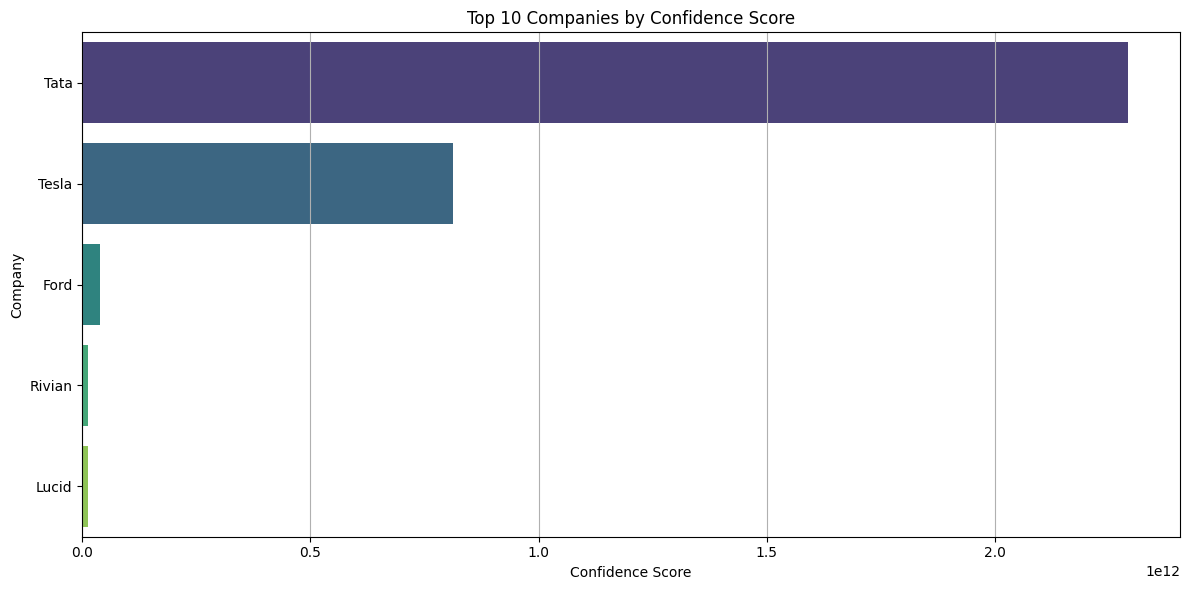

In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Load CSV
df = pd.read_csv("financial_analysis_full.csv")

# Preferred features
preferred_columns = [
    "Net Profit Margin", "ROA", "ROE",
    "Debt to Equity", "Operating Income",
    "Cash Flow", "Sentiment_Positive"
]

# Flexible selection of available columns
available_columns = [col for col in preferred_columns if col in df.columns]
print("✅ Using features:", available_columns)

# Ensure required columns are present
if not all(col in df.columns for col in ["Market Cap", "Company"]):
    raise KeyError("Missing required 'Market Cap' or 'Company' columns.")

# Drop missing values
df.dropna(subset=available_columns + ["Market Cap", "Company"], inplace=True)

# Normalize features
scaler = MinMaxScaler()
df[available_columns] = scaler.fit_transform(df[available_columns])

# Features and target
X = df[available_columns]
y = df["Market Cap"]

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# 📊 Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Convert Market Cap to categories for F1 Score (simple thresholds: low, mid, high)
def categorize_market_cap(value):
    if value < y.quantile(0.33):
        return 0  # Low
    elif value < y.quantile(0.66):
        return 1  # Medium
    else:
        return 2  # High

y_test_class = y_test.apply(categorize_market_cap)
y_pred_class = pd.Series(y_pred, index=y_test.index).apply(categorize_market_cap)
f1 = f1_score(y_test_class, y_pred_class, average='weighted')

# Print evaluation results
print("\n📈 Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"F1 Score (3-class): {f1:.4f}")

# 🔎 Predict full dataset for scoring
df["Confidence Score"] = model.predict(X)
final_df = df.sort_values("Confidence Score", ascending=False)

# Display top companies
print("\n🏆 FINAL CONFIDENCE SCORES:")
display(final_df[["Company", *available_columns, "Confidence Score"]])

# 📊 Barplot of top 10 companies
plt.figure(figsize=(12, 6))
sns.barplot(data=final_df.head(10), x="Confidence Score", y="Company", palette="viridis")
plt.title("Top 10 Companies by Confidence Score")
plt.xlabel("Confidence Score")
plt.ylabel("Company")
plt.grid(axis="x")
plt.tight_layout()
plt.show()
